# Autocodificadores

fonte: https://blog.keras.io/building-autoencoders-in-keras.html

Este notebook apresenta os autocodificadores.

<table align='left'>
<tr><td> <img src="../figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [2]:
import os
import keras.backend as K
K.set_image_data_format("channels_first")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plot

import sys
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.datasets import mnist

sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

## Código de apoio ao acompanhamento do treinamento

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt)    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=batch_size, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass
    model, cb = load_model_and_history(model_name)
    return model, cb

## Leitura do Dataset

In [5]:
(x_train, x_test), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.
print(x_train.shape, x_test.shape)


(60000, 784) (10000, 784)


## Teste inicial com pouquíssimas amostras (durante depuração ou rodar em CPU)

In [7]:
testing = False
if testing:
    n_samples = 2000
    X_train = x_train[:n_samples]
    n_samples_test = 500
    X_test = x_test[:n_samples_test]
else:
    X_train = x_train
    X_test = x_test
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


<table align='left'>
<tr><td> <img src="../figures/autoencoder_1.png",width=600pt> </td></tr>
</table>

## Criando a Rede

In [8]:
input_img = Input(shape=(28*28,))

x = Dense(512, activation='relu')(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(2, activation='linear', name='encoded')(x)

# at this point the representation is 2-dimensional

x = Dense(128, activation='relu')(encoded)
x = Dense(512, activation='relu')(x)
decoded = Dense(28*28, activation='linear')(x)

autoencoder = Model(input_img, decoded)

    
encoder = Model(autoencoder.input, autoencoder.layers_by_depth[3][0].output)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
encoded (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total para

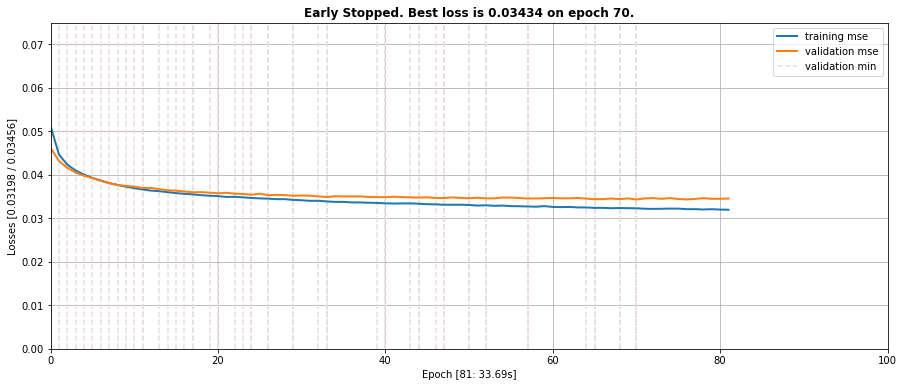

In [9]:
model_name = '../../models/autoencoder_dense_2'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(),
    'batch_size': 128, 
    'nepochs':    100,
    'patience':   10,
    'ploss':      0.075,
    'reset':      True,
}

model_trained,_ = train_network(autoencoder, 
                                X_train, X_train, 
                                X_test, X_test, **fit_params);

In [11]:
model_trained.evaluate(X_test, X_test, batch_size=128, verbose=1)

 9984/10000 [============================>.] - ETA: 0s 

0.034335948508977893

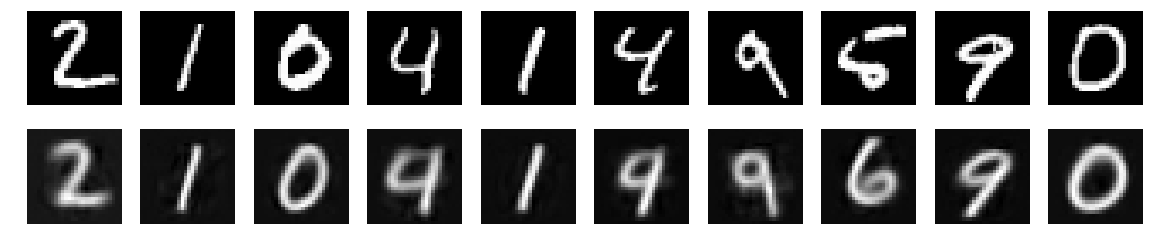

In [12]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plot.figure(figsize=(20, 4))
plot.gray()
for i in range(1,n+1):
    # display original
    ax = plot.subplot(2, n, i)
    plot.imshow(x_test[i].reshape(28, 28))
    plot.axis('off')

    # display reconstruction
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs[i].reshape(28, 28))
    plot.axis('off')
plot.show()


## Mostra plot 2D das classes, no espaço codificado

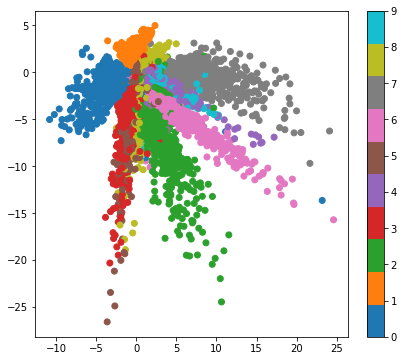

In [18]:
x_test_encoded = encoder.predict(x_test, batch_size=100)
plot.figure(figsize=(7, 6))
plot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plot.cm.tab10)
plot.colorbar();

In [19]:
%cp ../../models/autoencoder_dense_2.model ../../models/autoencoder_dense_2.model
%cp ../../models/autoencoder_dense_2.history ../../models/autoencoder_dense_2.history

## Treinando uma camada de cada vez

<table align='left'>
<tr><td> <img src="../figures/autoencoder_2.png"> </td></tr>
</table>


## Rede com camadas pré-treinadas

<table align='left'>
<tr><td> <img src="../figures/autoencoder_3.png"> </td></tr>
</table>
